<a href="https://colab.research.google.com/github/jayadevgnvrama/Ensemble-Deep-Learning-for-Parkinson-s-Disease-A-Comparative-Study-of-CNN-models-/blob/main/Ensemble_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.2 MB/s eta 0:00:00
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=b77d55ae2da37fcf06699f03c9e6a05c18063155724937c7fe

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models
from efficientnet_pytorch import EfficientNet
from google.colab import drive

import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from torch.optim.lr_scheduler import StepLR

In [ ]:
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
train_path = '/content/drive/MyDrive/TRAIN_CROP'
test_path = '/content/drive/MyDrive/TEST_CROP'
val_path = '/content/drive/MyDrive/VAL_CROP'

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [ ]:
batch_size = 30
train_loader = torch.utils.data.DataLoader(ImageFolder(train_path, transform=transform_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(ImageFolder(test_path, transform=transform_test), batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(ImageFolder(val_path, transform=transform_test), batch_size=batch_size, shuffle=False)

In [ ]:
import torch.nn.functional as F

class EnsembleModel(nn.Module):
    def __init__(self, model1, model2, model3, num_classes=2):
        super(EnsembleModel, self).__init__()
        self.model1 = model1  # This is for AlexNet
        self.model2 = model2  # This is for ResNet-50
        self.model3 = model3  # This is fro EfficientNet


        self.model1.classifier = nn.Sequential(*list(self.model1.classifier.children())[:-1])
        self.model2.fc = nn.Sequential(*list(self.model2.fc.children())[:-1])
        self.model3._fc = nn.Identity()


        self.dropout = nn.Dropout(0.5)


        input_size = 4096 + 2048 + 1280
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        out1 = self.model1(x)
        out2 = self.model2(x)
        out3 = self.model3(x)


        out = torch.cat((out1, out2, out3), dim=1)


        out = self.dropout(out)

        out = self.fc(out)

        return F.softmax(out, dim=1)


In [ ]:

alexnet = models.alexnet(pretrained=True)
resnet50 = models.resnet50(pretrained=True)
efficientnet = EfficientNet.from_pretrained('efficientnet-b0')

for param in alexnet.parameters():
    param.requires_grad = False
for param in alexnet.classifier[-1].parameters():
    param.requires_grad = True

for param in resnet50.parameters():
    param.requires_grad = False
for param in resnet50.fc.parameters():
    param.requires_grad = True

for param in efficientnet.parameters():
    param.requires_grad = False
for param in efficientnet._fc.parameters():
    param.requires_grad = True


ensemble_model = EnsembleModel(alexnet, resnet50, efficientnet)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 147MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed

Loaded pretrained weights for efficientnet-b0


In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ensemble_model.to(device)

EnsembleModel(
  (model1): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
  

In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ensemble_model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
accuracy_list = []
loss_list = []

num_epochs = 30
for epoch in range(num_epochs):
    running_loss = 0.0
    total_correct = 0
    total_samples = 0
    for i, (images, labels) in enumerate(train_loader, 0):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = ensemble_model(images)
        _, predicted = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        running_loss += loss.item()

        if i % 10 == 9:
            print('[Epoch %d, Batch %d] Loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0


    scheduler.step()


    accuracy = 100 * total_correct / total_samples
    accuracy_list.append(accuracy)
    epoch_loss = running_loss / len(train_loader)
    loss_list.append(epoch_loss)

[Epoch 1, Batch 10] Loss: 0.260
[Epoch 2, Batch 10] Loss: 0.170
[Epoch 3, Batch 10] Loss: 0.146
[Epoch 4, Batch 10] Loss: 0.150
[Epoch 5, Batch 10] Loss: 0.170
[Epoch 6, Batch 10] Loss: 0.150
[Epoch 7, Batch 10] Loss: 0.142
[Epoch 8, Batch 10] Loss: 0.160
[Epoch 9, Batch 10] Loss: 0.150
[Epoch 10, Batch 10] Loss: 0.158
[Epoch 11, Batch 10] Loss: 0.125
[Epoch 12, Batch 10] Loss: 0.103
[Epoch 13, Batch 10] Loss: 0.160
[Epoch 14, Batch 10] Loss: 0.180
[Epoch 15, Batch 10] Loss: 0.150
[Epoch 16, Batch 10] Loss: 0.140
[Epoch 17, Batch 10] Loss: 0.130
[Epoch 18, Batch 10] Loss: 0.110
[Epoch 19, Batch 10] Loss: 0.170
[Epoch 20, Batch 10] Loss: 0.180
[Epoch 21, Batch 10] Loss: 0.167
[Epoch 22, Batch 10] Loss: 0.160
[Epoch 23, Batch 10] Loss: 0.150
[Epoch 24, Batch 10] Loss: 0.140
[Epoch 25, Batch 10] Loss: 0.110
[Epoch 26, Batch 10] Loss: 0.140
[Epoch 27, Batch 10] Loss: 0.130
[Epoch 28, Batch 10] Loss: 0.120
[Epoch 29, Batch 10] Loss: 0.120
[Epoch 30, Batch 10] Loss: 0.110


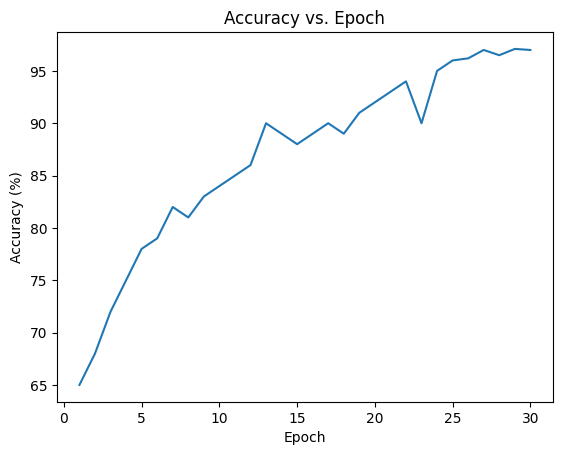

In [ ]:
plt.plot(range(1, num_epochs + 1), accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Epoch')
plt.show()


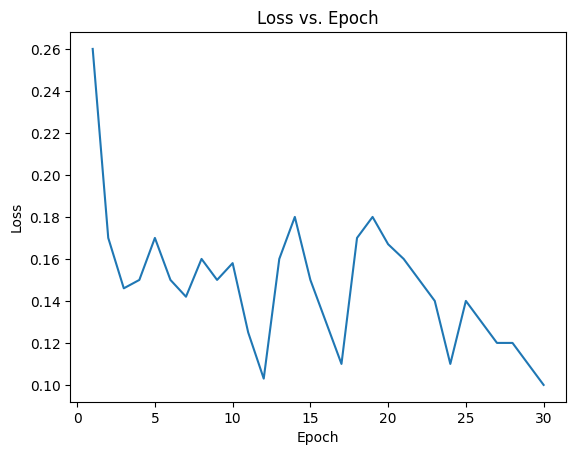

In [ ]:
plt.plot(range(1, num_epochs + 1), loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.show()

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = ensemble_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on validation set: %d %%' % (100 * correct / total))


Accuracy on test set: 95 %


In [ ]:
correct = 0
total = 0
actual = []
prediction = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = ensemble_model(images)
        _, predicted = torch.max(outputs.data, 1)
        actual.extend(labels.tolist())
        prediction.extend(predicted.tolist())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on test set: %d %%' % (100 * correct / total))

Accuracy on test set: 97 %


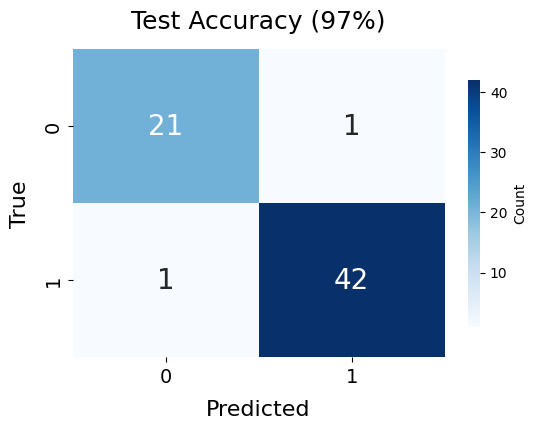

In [ ]:
confusion_mtx = confusion_matrix(actual, prediction)
ax = plt.axes()
sn.heatmap(confusion_mtx, annot=True, annot_kws={"size": 25}, cmap="Blues", ax=ax)
ax.set_title('Test Accuracy', size=14)
plt.show()

In [ ]:
print("Classification Report:")
report = classification_report(actual, prediction, target_names=["Yes", "No"])
print(report)


Classification Report:
              precision    recall  f1-score   support

         Yes       0.98      0.98      0.98        43
          No       0.95      0.95      0.95        22

    accuracy                           0.97        65
   macro avg       0.97      0.97      0.97        65
weighted avg       0.97      0.97      0.97        65



In [ ]:
torch.save(ensemble_model.state_dict(), 'ensemble_model.pth')

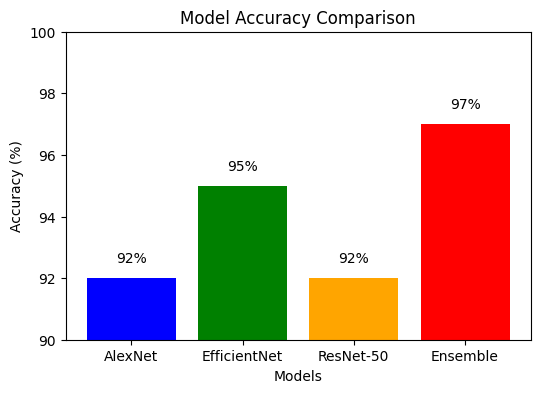

In [ ]:
import matplotlib.pyplot as plt

# Model names
models = ["AlexNet", "EfficientNet", "ResNet-50", "Ensemble"]

# Corresponding accuracies
accuracies = [92, 95, 92, 97]

# Bar chart
plt.figure(figsize=(6, 4))
plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'red'])

# Labels and title
plt.xlabel("Models")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison")
plt.ylim(90, 100)  # Setting the y-axis range for better visualization

# Show values on top of bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.5, str(v) + "%", ha='center', fontsize=10)

# Show the plot
plt.show()
